# Preparation

In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import seaborn as sns

sc.logging.print_header()
# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3  # errors (0), warnings (1), info (2), hints (3)

sns.set_style("white")

np.random.seed(0)
from sklearn.metrics.cluster import adjusted_rand_score
import warnings
import src.logger as l
warnings.filterwarnings("ignore")

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.3 pandas==1.3.5 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


In [2]:
adata = sc.read_h5ad('F:/UGIMC/Data/Starmap/STARmap_20180505_BY3_1k.h5ad')
adata.X = sparse.csr_matrix(adata.X)
# sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, inplace=True)
adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label'
    uns: 'label_colors'
    obsm: 'spatial'

In [3]:
# banksy preprocess
from sklearn.neighbors import NearestNeighbors

visualize_weights = True
num_neighbours = 8

nbrs = NearestNeighbors(algorithm='ball_tree').fit(adata.obsm['spatial'])
distances, indices = nbrs.kneighbors(n_neighbors=num_neighbours)
median_cell_distance = np.median(distances)
print(f"\nMedian distance to closest cell = {median_cell_distance}")
distances.shape, indices.shape


Median distance to closest cell = 316.6983136920192


((1207, 8), (1207, 8))

Maximum weight: 0.5193621470087381



(-630.5286230210681, 14490.623535171215, -6754.970494562382, 282.2613648040552)

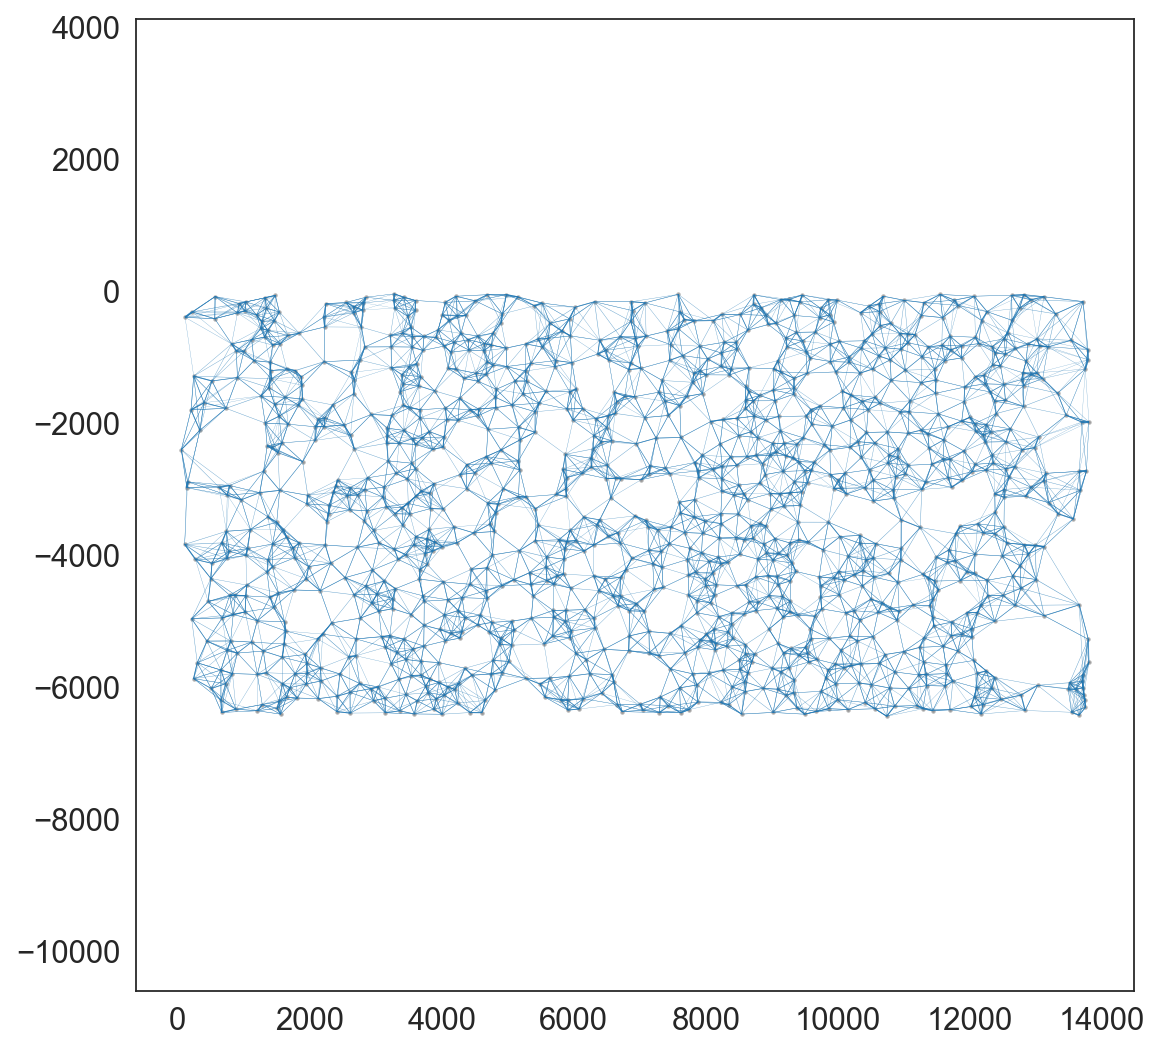

In [4]:
from src.utils import generate_spatial_weights_fixed_nbrs, plot_graph_weights

weights_graph, distance_graph = generate_spatial_weights_fixed_nbrs(adata.obsm['spatial'], num_neighbours=num_neighbours, decay_type='scaled_gaussian', nbr_object=nbrs, verbose=False)
position = adata.obsm['spatial'].copy()
plot_graph_weights(position, sparse.csr_matrix(np.nan_to_num(weights_graph.A)), max_weight=1, markersize=1, figsize=(8, 8))
ax = plt.gca()
ax.axis('equal')

In [5]:
from src.utils import weighted_concatenate, zscore, matrix_to_adata

gene_list = adata.var.index

nbrhood_contribution = 0.8

neighbour_agg_matrix = weights_graph @ adata.X

if sparse.issparse(adata.X):
    concatenated = sparse.hstack((adata.X, neighbour_agg_matrix), )
else:
    concatenated = np.concatenate((adata.X, neighbour_agg_matrix), axis=1,)

matrix = weighted_concatenate(zscore(adata.X, axis=0), zscore(neighbour_agg_matrix, axis=0), nbrhood_contribution)


if sparse.issparse(matrix):
    st_dev_pergene = matrix.toarray().std(axis=0)
else:
    st_dev_pergene = matrix.std(axis=0)

enhanced_data = matrix_to_adata(matrix, adata)
display(enhanced_data)

num_nbrs: 1020


AnnData object with n_obs × n_vars = 1207 × 2040
    obs: 'Total_counts', 'X', 'Y', 'label'
    var: 'is_nbr'
    uns: 'label_colors'
    obsm: 'spatial'

In [7]:
sc.pp.pca(enhanced_data, n_comps=20)
low_dim_x = enhanced_data.obsm['X_pca']

computing PCA
    with n_comps=8
    finished (0:00:00)


In [8]:
# from scipy.io import loadmat
# mat = loadmat('F:/1214/MCSL-LTC-Code/scTData/starmap.mat')
# data = mat['data']
# gt = mat['gt'].T
# spatial_network = data[0][0][:1207].astype(np.float32)
# expression = data[0][1][:1207].astype(np.float32)

In [9]:
expression = low_dim_x
spatial_network = weights_graph.A

# Running stACN

In [10]:
import src.st_acn as stACN
import src.logger as l
import os
import sys
output_data_path = "./Output/"
log_path = os.path.join(output_data_path, 'log')
l.initlog(log_path, )
l.logger.info(f'[call] run st_acn_master')
Z_all =  stACN.stACN(expression, spatial_network, lamb=0.0001, dim=200)
l.logger.info(f'[call] run st_acn_master done')

2023-12-29 01:51:55,363 INFO 2329548700.py:8  :  [call] run st_acn_master
  0%|                                                                                                                                                           | 0/50 [00:00<?, ?it/s]2023-12-29 01:51:59,507 INFO stACN.py:54  :  [RunCSolver]iter = 0 calculate E
2023-12-29 01:52:00,232 INFO stACN.py:71  :  [RunCSolver]iter = 0 calculate E end
2023-12-29 01:52:00,278 INFO stACN.py:76  :  [RunCSolver]iter = 0 wshrinkObj
2023-12-29 01:52:00,782 INFO stACN.py:92  :  [RunCSolver]iter = 0 mu=0.0001
2023-12-29 01:52:00,787 INFO stACN.py:93  :  [RunCSolver]iter = 0 Ys[i]=9.272455787568868e-05
2023-12-29 01:52:00,791 INFO stACN.py:94  :  [RunCSolver]iter = 0 Yh[i]=9.272455787568868e-05
2023-12-29 01:52:00,862 INFO stACN.py:92  :  [RunCSolver]iter = 0 mu=0.0001
2023-12-29 01:52:00,865 INFO stACN.py:93  :  [RunCSolver]iter = 0 Ys[i]=8.815034881817666e-05
2023-12-29 01:52:00,868 INFO stACN.py:94  :  [RunCSolver]iter = 0 Yh[i]=

2023-12-29 01:52:10,445 INFO stACN.py:71  :  [RunCSolver]iter = 6 calculate E end
2023-12-29 01:52:10,488 INFO stACN.py:76  :  [RunCSolver]iter = 6 wshrinkObj
2023-12-29 01:52:10,961 INFO stACN.py:92  :  [RunCSolver]iter = 6 mu=0.0064
2023-12-29 01:52:10,963 INFO stACN.py:93  :  [RunCSolver]iter = 6 Ys[i]=0.003475275264323164
2023-12-29 01:52:10,965 INFO stACN.py:94  :  [RunCSolver]iter = 6 Yh[i]=0.003475275264323164
2023-12-29 01:52:11,011 INFO stACN.py:92  :  [RunCSolver]iter = 6 mu=0.0064
2023-12-29 01:52:11,016 INFO stACN.py:93  :  [RunCSolver]iter = 6 Ys[i]=0.0032275453018307137
2023-12-29 01:52:11,019 INFO stACN.py:94  :  [RunCSolver]iter = 6 Yh[i]=0.0032275453018307137
2023-12-29 01:52:11,021 INFO stACN.py:98  :  [RunCSolver]iter = 6 calculate  errp errs
2023-12-29 01:52:11,463 INFO stACN.py:103  :  [RunCSolver]iter = 6 max_err=1.037765657004361
2023-12-29 01:52:11,465 INFO stACN.py:104  :  [RunCSolver]iter = 6 errs=1.0013468786934008
2023-12-29 01:52:11,466 INFO stACN.py:105  :

2023-12-29 01:52:20,735 INFO stACN.py:94  :  [RunCSolver]iter = 12 Yh[i]=0.030803398243336097
2023-12-29 01:52:20,775 INFO stACN.py:92  :  [RunCSolver]iter = 12 mu=0.4096
2023-12-29 01:52:20,777 INFO stACN.py:93  :  [RunCSolver]iter = 12 Ys[i]=0.030107136311969415
2023-12-29 01:52:20,779 INFO stACN.py:94  :  [RunCSolver]iter = 12 Yh[i]=0.030107136311969415
2023-12-29 01:52:20,780 INFO stACN.py:98  :  [RunCSolver]iter = 12 calculate  errp errs
2023-12-29 01:52:21,195 INFO stACN.py:103  :  [RunCSolver]iter = 12 max_err=0.17379505016179955
2023-12-29 01:52:21,196 INFO stACN.py:104  :  [RunCSolver]iter = 12 errs=0.17365307359294802
2023-12-29 01:52:21,198 INFO stACN.py:105  :  [RunCSolver]iter = 12 errp=0.00015206519132168265
 26%|█████████████████████████████████████▉                                                                                                            | 13/50 [00:21<00:59,  1.60s/it]2023-12-29 01:52:21,200 INFO stACN.py:54  :  [RunCSolver]iter = 13 calculate E
2023-1

2023-12-29 01:52:30,333 INFO stACN.py:94  :  [RunCSolver]iter = 18 Yh[i]=0.03173466003076678
2023-12-29 01:52:30,333 INFO stACN.py:98  :  [RunCSolver]iter = 18 calculate  errp errs
2023-12-29 01:52:30,738 INFO stACN.py:103  :  [RunCSolver]iter = 18 max_err=0.0018826979388970135
2023-12-29 01:52:30,740 INFO stACN.py:104  :  [RunCSolver]iter = 18 errs=0.0018812182313226863
2023-12-29 01:52:30,742 INFO stACN.py:105  :  [RunCSolver]iter = 18 errp=1.573511721441797e-06
 38%|███████████████████████████████████████████████████████▍                                                                                          | 19/50 [00:31<00:49,  1.59s/it]2023-12-29 01:52:30,745 INFO stACN.py:54  :  [RunCSolver]iter = 19 calculate E
2023-12-29 01:52:31,361 INFO stACN.py:71  :  [RunCSolver]iter = 19 calculate E end
2023-12-29 01:52:31,407 INFO stACN.py:76  :  [RunCSolver]iter = 19 wshrinkObj
2023-12-29 01:52:31,906 INFO stACN.py:92  :  [RunCSolver]iter = 19 mu=52.4288
2023-12-29 01:52:31,908 INFO s

2023-12-29 01:52:40,975 INFO stACN.py:104  :  [RunCSolver]iter = 24 errs=2.054233934173282e-05
2023-12-29 01:52:40,976 INFO stACN.py:105  :  [RunCSolver]iter = 24 errp=2.0020788745026907e-08
 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 25/50 [00:41<00:42,  1.68s/it]2023-12-29 01:52:40,979 INFO stACN.py:54  :  [RunCSolver]iter = 25 calculate E
2023-12-29 01:52:41,601 INFO stACN.py:71  :  [RunCSolver]iter = 25 calculate E end
2023-12-29 01:52:41,640 INFO stACN.py:76  :  [RunCSolver]iter = 25 wshrinkObj
2023-12-29 01:52:42,142 INFO stACN.py:92  :  [RunCSolver]iter = 25 mu=3355.4432
2023-12-29 01:52:42,145 INFO stACN.py:93  :  [RunCSolver]iter = 25 Ys[i]=0.031219449304217
2023-12-29 01:52:42,148 INFO stACN.py:94  :  [RunCSolver]iter = 25 Yh[i]=0.031219449304217
2023-12-29 01:52:42,198 INFO stACN.py:92  :  [RunCSolver]iter = 25 mu=3355.4432
2023-12-29 01:52:42,201 INFO stACN.py:93  : 

# Clustering

In [11]:
import igraph as ig
import leidenalg
from natsort import natsorted
l.logger.info("[cluster] begin")
sources, targets = Z_all.nonzero()
ans_weight = Z_all[sources, targets]
g = ig.Graph(directed=True)
g.add_vertices(Z_all.shape[0])  # this adds adjacency.shape[0] vertices
g.add_edges(list(zip(sources, targets)))
g.es['weight'] = ans_weight

2023-12-29 01:52:49,947 INFO 842788194.py:4  :  [cluster] begin


In [12]:
# 尝试在学到的亲和图上直接执行leiden聚类算法。我们在单细胞上的聚类算法基本都失效了，也该尝试空间转录组领域的了。
partition_type = leidenalg.RBConfigurationVertexPartition
# clustering proper
partition_kwargs = {'weights': np.array(g.es['weight']).astype(np.float64), 'n_iterations': -1, 'seed': 42,'resolution_parameter': 1.2}

part = leidenalg.find_partition(g, partition_type, **partition_kwargs)
# store output into adata.obs
groups = np.array(part.membership)
leiden_label = pd.Categorical(
    values=groups.astype('U'),
    categories=natsorted(map(str, np.unique(groups))),
)
print(leiden_label)
adjusted_rand_score(pd.Categorical(enhanced_data.obs['label']).codes, leiden_label)

['0', '1', '3', '0', '5', ..., '0', '0', '3', '4', '4']
Length: 1207
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']


0.598574810758354

In [13]:
enhanced_data.obs['stACN'] = leiden_label
enhanced_data.obs['stACN'] = enhanced_data.obs['stACN'].astype('str')
enhanced_data.obs['stACN'] = enhanced_data.obs['stACN'].astype('category')

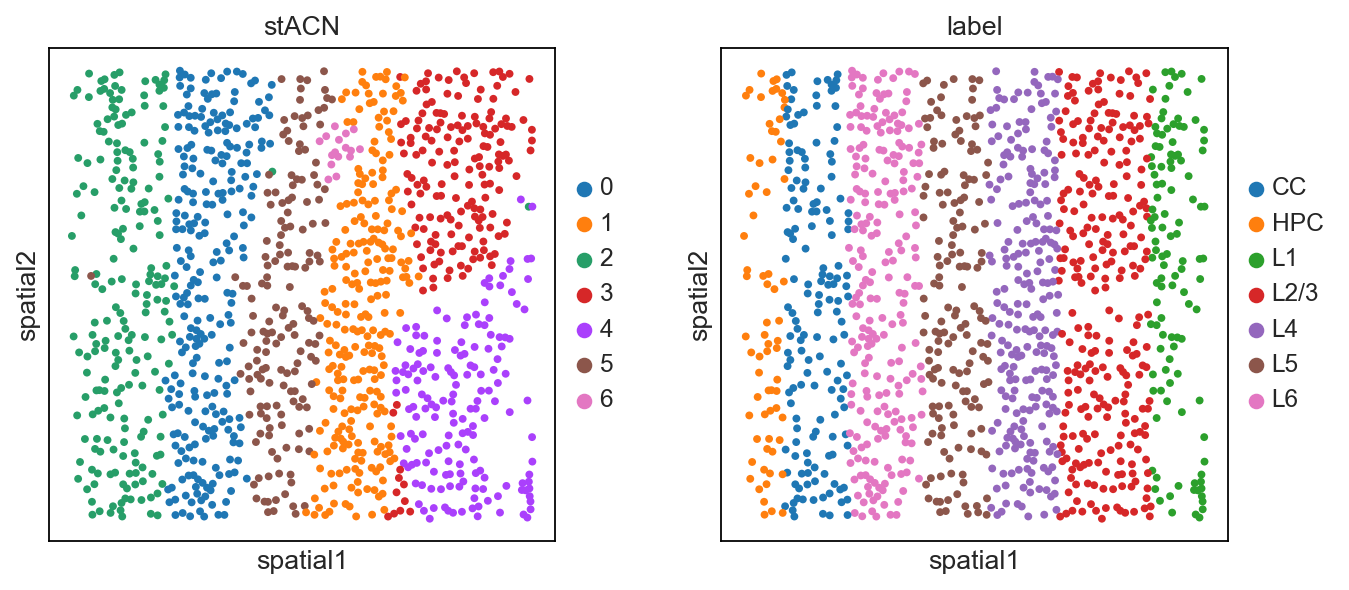

In [14]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=500, frameon=True, vector_friendly=False, fontsize=12, figsize=None, color_map=None, format='eps', facecolor=None, transparent=True, ipython_format='png2x')
sc.pl.embedding(enhanced_data, basis="spatial", color=['stACN', 'label'], s=50, show=True, save = "starMap")